https://www.kaggle.com/datasets/gulerosman/hg14-handgesture14-dataset

Flutter

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [17]:
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split

In [3]:
import re

In [4]:
from PIL import Image

In [5]:
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor
from torchvision.io import read_image
from torch.utils.data import DataLoader
from torchvision import transforms

In [24]:
import torch
import torch.nn as nn
import torch.nn.functional as torchF

# Data Reading

In [7]:
fileSets = []
data_path = 'data/'
for root,dirs,files in os.walk('data/'):
    fileSets.append(np.char.add(np.full(len(files),root),np.array(files)))
fileNames = np.array(fileSets).flatten()

In [8]:
allFilePd = pd.DataFrame(fileNames,columns=['fileName'])
allFilePd['label'] = allFilePd.fileName.str.extract("(\d?\d(?=\.jpg))").astype(int)

In [19]:
XTrain, XTest, yTrain, yTest = train_test_split(
    allFilePd.fileName,
    allFilePd.label,
    test_size=0.2,
    random_state=2021,
    stratify = allFilePd.label

)

In [107]:
XTrain = XTrain.to_numpy()
yTrain = yTrain.to_numpy()
XTest = XTest.to_numpy()
yTest = yTest.to_numpy()

In [ ]:
## TODO TURN NORMALIZE INTO DIV BY 255

In [108]:
imShrink32 = transforms.Compose([
    transforms.Resize((32,32)),
    transforms.ConvertImageDtype(torch.double),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    transforms.ToPILImage()
])

In [109]:
class GestImgDataset(Dataset):
    def __init__(self,
                 fileDirs : np.array,
                 labels : np.array,
                 transform=None, target_transform=None):
        
        self.img_labels = labels
        self.img_dir = fileDirs
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = self.img_dir[idx]
        image = read_image(img_path)
        label = self.img_labels[idx]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

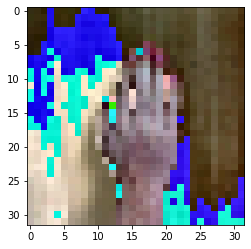

In [114]:
plt.imshow(imShrink32(read_image(XTrain[19])))

In [60]:
trainDataset = GestImgDataset(XTrain,yTrain,imShrink32)
trainDataloader = DataLoader(trainDataset, batch_size=128, shuffle=True)

In [61]:
for i, (img,label) in enumerate(trainDataloader):
    if i>=50:
        break
    else:
        print(img.shape)

KeyError: 1595

# CNN

In [51]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 8, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(8, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(torchF.relu(self.conv1(x)))
        x = self.pool(torchF.relu(self.conv2(x)))
        x = torch.flatten(x, 1) 
        x = torchF.relu(self.fc1(x))
        x = torchF.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [52]:
cnn = CNN()

In [53]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cnn.parameters(),lr=0.001)

In [54]:
num_epochs = 40

In [55]:
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, (imgs,label) in enumerate(trainDataloader):
        optimizer.zero_grad()
        
        outputs = cnn(imgs)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        if i % 200 == 199:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 200:.3f}')
            running_loss = 0.0

KeyError: 2190